In [3]:
import requests
import json
import time
from datetime import datetime
import pandas as pd
from imblearn.over_sampling import SMOTE


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [233]:
!pip3 install seaborn

In [234]:
!pip3 install imblearn

In [4]:
import seaborn as sn

In [5]:
import numpy as np
from numpy import savetxt
from numpy import asarray
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

# Data description
- The data is collected from benchmark, simulated malware and simulated stress application
- 12 metrics are listed as below:
 
 - 0) **cpu_system**: The “system” CPU state shows the amount of CPU time used by the kernel. The kernel is responsible for low-level tasks, like interacting with the hardware, memory allocation, communicating between OS processes, running device drivers and managing the file system.
 - 1) **cpu_idle**: The “idle” CPU state shows the CPU time that’s not actively being used. **=> cpu_total = 1- cpu_idle**: is the total consumption of CPU 
 - 2) **cpu_user**: The "user" CPU state shows CPU time used by user space processes. These are higher-level processes, like your application, or the database server running on your machine.
 - 3) **cpu_iowait**: The "iowait" is a sub category of the “idle” state. It marks time spent waiting for input or output operations, like reading or writing to disk
 - 4) **pod_count**: Num of pod services controlled by Kubernettes
 - 5) **system_load**: The load of a system is essentially the number of processes active at any given time. When idle, the load is 0. When a process starts, the load is incremented by 1
 - 6) **mem_total**: Total amount of Memory
 - 7) **mem_avail**: Total amount of free mem
 - 8) **disk_io**: Disk I/O includes read or write or input/output operations (defined in KB/s) involving a physical disk. In simple words, it is the speed with which the data transfer takes place between the hard disk drive and RAM, or basically it measures active disk I/O time
 - 9) **disk_space_used**: refers to the portion or percentage of computer storage that is currently in use
 - 10) **net_received**
 - 11) **net_transmit**

Other metrics related to timestamp
 - 12) timestamp (is the index of pandas)
 - 13) year
 - 14) month
 - 15) day
 - 16) hour
 - 17) minute
 - 18) second

 Classified by metric : label with 0 and 1
 
 Ref:
 https://blog.appsignal.com/2018/03/06/understanding-cpu-statistics.html
 https://blog.appsignal.com/2018/03/28/understanding-system-load-and-load-averages.html

In [237]:
# !rm -rf CBT
# !git clone https://github.com/levanthanh3005/CBT

In [6]:
def viewAllDataFromFolder(dataPath,prefix):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    dataList = []
    for fs in onlyfiles:
        if fs[:2]==prefix:
            print(fs)
            count = count + 1
            dataItem = pd.read_pickle(dataPath+"/"+fs)
            dataList.append(dataItem)
    frame = pd.concat(dataList)
    return frame

In [7]:
dataset = viewAllDataFromFolder("CBT/data","8-")
#Good Result at 1629489780:

8-1629576360-tan-k2-1.pkl
8-1629487770-tan-k3-0.pkl
8-1629797400-tan-k3-0.pkl
8-1629944340-tan-k3-0.pkl
8-1630150200-tan-k3-1.pkl
8-1629810600-tan-km-1.pkl
8-1629660180-tan-km-1.pkl
8-1630238040-tan-k3-0.pkl
8-1629634500-tan-k3-0.pkl
8-1629660180-tan-k2-1.pkl
8-1629793080-tan-k2-1.pkl
8-1629876780-tan-km-1.pkl
8-1629397800-tan-k2-1.pkl
8-1629397800-tan-km-1.pkl
8-1629876780-tan-k2-1.pkl
8-1629797400-tan-k2-1.pkl
8-1629713460-tan-km-1.pkl
8-1630323180-tan-k3-0.pkl
8-1630323180-tan-km-1.pkl
8-1629793080-tan-km-1.pkl
8-1630052880-tan-km-1.pkl
8-1629944340-tan-k2-1.pkl
8-1629367800-tan-km-1.pkl
8-1629367800-tan-k2-1.pkl
8-1629576360-tan-k3-0.pkl
8-1630052880-tan-k2-1.pkl
8-1629612720-tan-km-1.pkl
8-1630052880-tan-k3-1.pkl
8-1629944340-tan-km-1.pkl
8-1629314880-tan-km-1.pkl
8-1629634500-tan-k2-1.pkl
8-1629487770-tan-k2-1.pkl
8-1629797400-tan-km-1.pkl
8-1629487770-tan-km-1.pkl
8-1629489780-tan-km-1.pkl
8-1629576360-tan-km-1.pkl
8-1629397800-tan-k3-1.pkl
8-1629461730-tan-k2-1.pkl
8-1629461730

In [8]:
dataset = dataset.reset_index().fillna(0)

In [9]:
dataset.head()

index     timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  \
0    0.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
1    1.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
2    2.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
3    3.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
4    4.0  1.629576e+09    0.025000  0.908000  0.045000    0.000000        6.0   

   system_load     mem_total     mem_avail   disk_io  disk_space_used  \
0         0.12  1.911521e+09  2.174521e+09  0.005067         0.534038   
1         0.12  1.911521e+09  2.174521e+09  0.005067         0.534038   
2         0.10  1.911755e+09  2.174288e+09  0.010400         0.534295   
3         0.10  1.911755e+09  2.174288e+09  0.010400         0.534295   
4         0.07  1.911210e+09  2.174833e+09  0.000800         0.534296   

    net_received   net_transmit    node  label  second  
0  951905.066667  899240.000000  tan-k2      1     0.0  
1  951905.066667  899240.000000  tan-k2      1     8.0  
2  771843.200000  541984.000000  tan-k2      1    16.0  
3  771843.200000  541984.000000  tan-k2      1    24.0  
4  849244.266667  771101.333333  tan-k2      1    32.0

# Data Shape and Label Count

In [10]:
print("Data Shape",dataset.shape)
print("Label counts:")
print(dataset["label"].value_counts())
print("8 data item per 1 minute")
print((dataset.shape[0] / 8)/60," hours")
print(((dataset.shape[0] / 8)/60)/24," days")
print("Num of data item with 10 min:",(dataset.shape[0] / 8)/10)

Data Shape (263109, 17)
Label counts:
1    207020
0     56089
Name: label, dtype: int64
8 data item per 1 minute
548.14375  hours
22.839322916666664  days
Num of data item with 10 min: 3288.8625


# Rebalance data

In [11]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

# Data Overview

In [12]:
dataset["timemm"] = dataset['timestamp']
dataset['timemm'] = dataset['timemm'].apply(lambda x: datetime.fromtimestamp(x))
dataset["year"] = dataset['timemm'].apply(lambda x:x.year)
dataset["month"] = dataset['timemm'].apply(lambda x:x.month)
dataset["day"] = dataset['timemm'].apply(lambda x:x.day)
dataset["hour"] = dataset['timemm'].apply(lambda x:x.hour)
dataset["minute"] = dataset['timemm'].apply(lambda x:x.minute)
dataset["second"] = dataset['timemm'].apply(lambda x:x.second)
del dataset['timemm']

dataset["node"] = dataset["node"].apply(lambda x : 2 if x=="tan-k2" else 3 if x=="tan-k3" else 1 if x=="tan-km" else x)
dataset["cpu_total"] = 1 - dataset["cpu_idle"]

dataset["cpu_user_rate"] = dataset["cpu_user"] / dataset["cpu_total"]
dataset["cpu_system_rate"] = dataset["cpu_system"] / dataset["cpu_total"]


## Proprotion of nodes

In [13]:
print(dataset["node"].value_counts())
dataset.head()

3    88664
2    88664
1    85781
Name: node, dtype: int64


index     timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  \
0    0.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
1    1.0  1.629576e+09    0.024000  0.906000  0.052667    0.000333        6.0   
2    2.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
3    3.0  1.629576e+09    0.034333  0.895667  0.045667    0.003000        6.0   
4    4.0  1.629576e+09    0.025000  0.908000  0.045000    0.000000        6.0   

   system_load     mem_total     mem_avail  ...  label  second  year  month  \
0         0.12  1.911521e+09  2.174521e+09  ...      1       0  2021      8   
1         0.12  1.911521e+09  2.174521e+09  ...      1       8  2021      8   
2         0.10  1.911755e+09  2.174288e+09  ...      1      16  2021      8   
3         0.10  1.911755e+09  2.174288e+09  ...      1      24  2021      8   
4         0.07  1.911210e+09  2.174833e+09  ...      1      32  2021      8   

   day  hour  minute  cpu_total  cpu_user_rate  cpu_system_rate  
0   21    20       6   0.094000       0.560284         0.255319  
1   21    20       6   0.094000       0.560284         0.255319  
2   21    20       6   0.104333       0.437700         0.329073  
3   21    20       6   0.104333       0.437700         0.329073  
4   21    20       6   0.092000       0.489130         0.271739  

[5 rows x 25 columns]

In [14]:
def normalizeColumn(datas):
  cols = datas.columns
  for e in range(0,12):
    normalized_df=(datas[cols[e]]-datas[cols[e]].mean())/datas[cols[e]].std()
    datas[cols[e]] = normalized_df
  return datas

def viewMetric(metric, datas):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")
    ndf0 = ndf[ndf["label"]==0]
    ndf1 = ndf[ndf["label"]==1]

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0")
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1")

def viewMetricByNode(metric, datas,node):
    ndf = datas[[metric,"label","node"]]
#     print("View each label in a graph and put them next to others")
#     print("Calculate min max std ..")

    ndf0 = ndf[(ndf["label"]==0) & (ndf["node"]==node)]
    ndf1 = ndf[(ndf["label"]==1) & (ndf["node"]==node)]
    print("---",metric)
    print("-------Label=0:max",ndf0[metric].max()," min:",ndf0[metric].min())
    print("-------Label=1:max",ndf1[metric].max()," min:",ndf1[metric].min())

    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(15, 3)
    ax0.plot(ndf0[metric].to_numpy())
    ax0.set_title(metric+" with label 0 - node "+str(node))
    ax1.plot(ndf1[metric].to_numpy())
    ax1.set_title(metric+" with label 1 - node "+str(node))
    
def viewAllMetrics(datas):
    cols = datas.columns
    for e in range(0,12):
        viewMetric(cols[e],datas)

def viewAllMetricsByNode(datas,node="2"):
    cols = datas.columns
    datasort = datas.sort_values(by=['timestamp'])
    for e in range(0,len(cols)):
#         print(e," ",cols[e])
        if (cols[e]!='label' and cols[e]!='node') :
            viewMetricByNode(cols[e],datasort,node)

## Normalize data

In [15]:
datasetnorm = normalizeColumn(dataset)
# datasetnorm = dataset

In [16]:
datasetnorm[(datasetnorm["cpu_user_rate"]>50) & (datasetnorm["cpu_user_rate"]<5000)]

Empty DataFrame
Columns: [index, timestamp, cpu_system, cpu_idle, cpu_user, cpu_iowait, pod_count, system_load, mem_total, mem_avail, disk_io, disk_space_used, net_received, net_transmit, node, label, second, year, month, day, hour, minute, cpu_total, cpu_user_rate, cpu_system_rate]
Index: []

[0 rows x 25 columns]

## Overview of data

In [17]:
def mergeWithDiff(df):
    nodeList = df['node'].unique()
    lsDfn = []
    dperiod = 5
    for n in nodeList:
#         print("Node:",n)
        dfn = df[df['node']==n]
        dfn = dfn.sort_values(by=['timestamp'])
        dfn = dfn.diff(periods=dperiod).add_prefix('diff_')
#         print(dfn)
        lsDfn.append(dfn)
    dffn = pd.concat(lsDfn)
    dn = pd.concat([df, dffn], axis=1)
    dn = dn.fillna(0)
    return dn

In [250]:
# datasetnormwdiff = mergeWithDiff(datasetnorm)

--- index
-------Label=0:max 1.3169068780240916  min: -0.7595534423969634
-------Label=1:max 1.3167903391206008  min: -0.7594464711464017
--- timestamp
-------Label=0:max 0.7598941490129197  min: -1.3167354280531822
-------Label=1:max 0.7592402571189971  min: -1.3167354280531822
--- cpu_system
-------Label=0:max 12.163066314874605  min: -1.6116267233948172
-------Label=1:max 3.6832424187604227  min: -1.6116267233948172
--- cpu_idle
-------Label=0:max 1.1054425306833038  min: -1.5912345557969536
-------Label=1:max 1.0306413881703476  min: -1.5912345557969536
--- cpu_user
-------Label=0:max 2.259065965696496  min: -1.110366994892706
-------Label=1:max 0.8924355613227716  min: -1.110366994892706
--- cpu_iowait
-------Label=0:max 14.49530804811659  min: -0.2594431650962717
-------Label=1:max 17.952278620990533  min: -0.2594431650962717
--- pod_count
-------Label=0:max 0.07551703794854892  min: -1.959475235516217
-------Label=1:max 0.07551703794854892  min: -0.828923972480236
--- system_loa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- cpu_user_rate
-------Label=0:max 1.0839999999986807  min: 0.0
-------Label=1:max 1.02754237287617  min: 0.0
--- cpu_system_rate
-------Label=0:max 0.6477777777778101  min: 0.0
-------Label=1:max 0.5904761904760164  min: 0.0


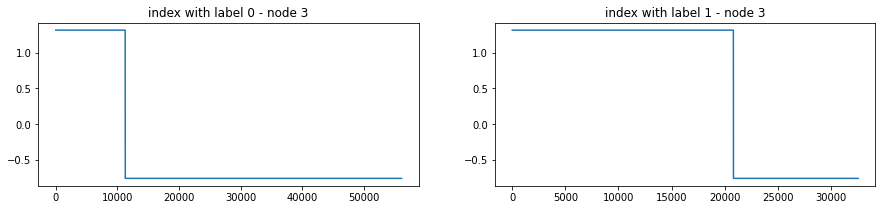

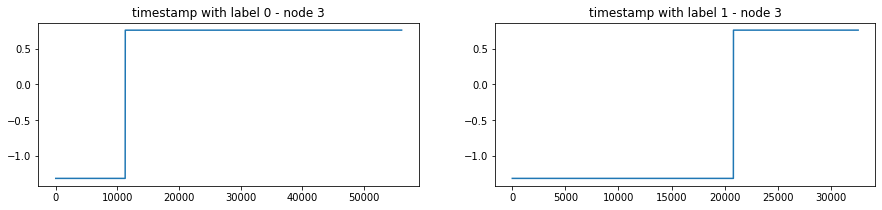

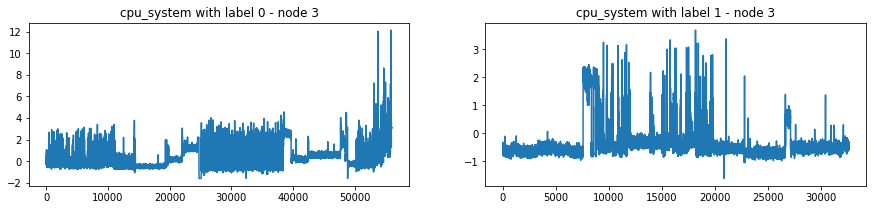

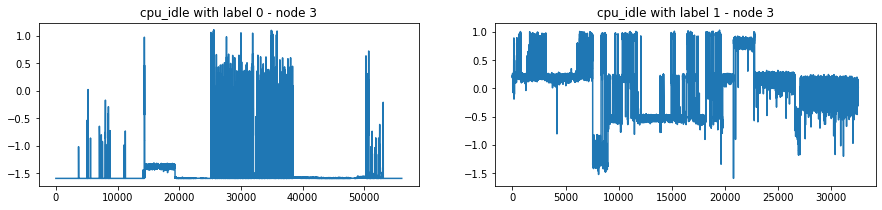

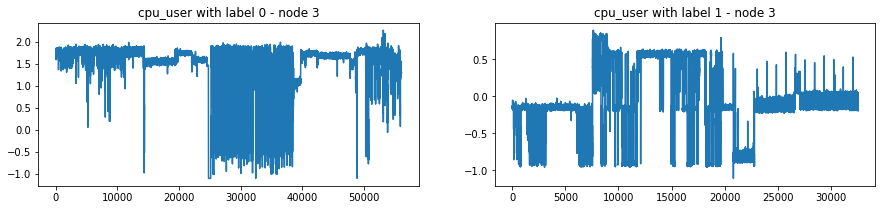

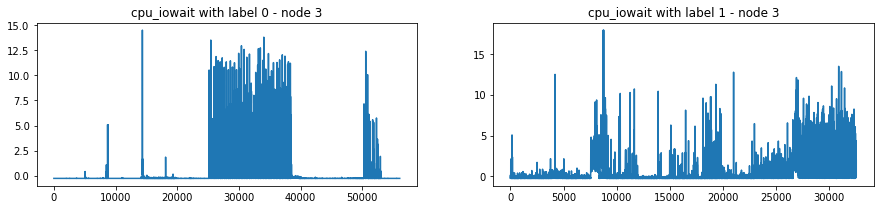

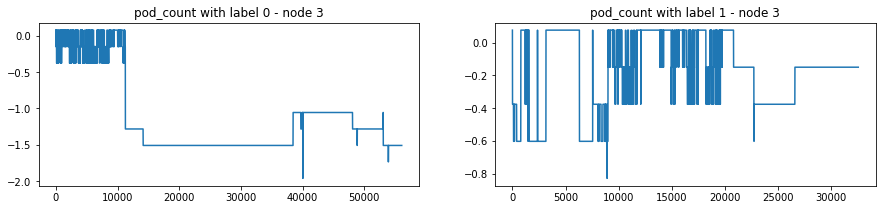

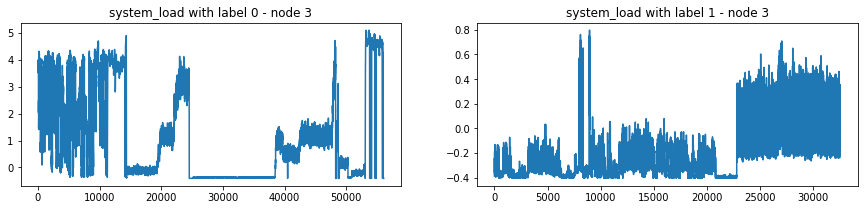

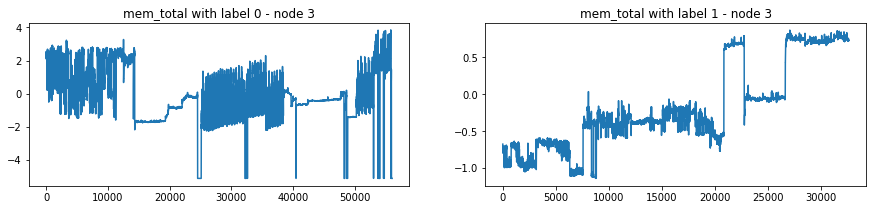

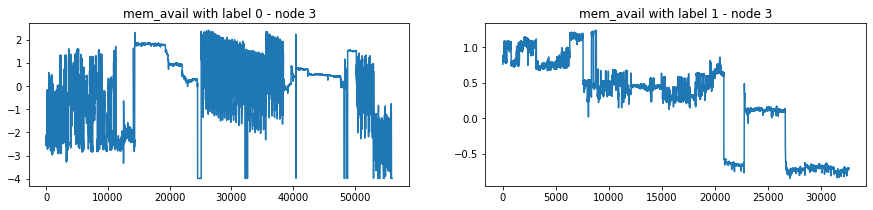

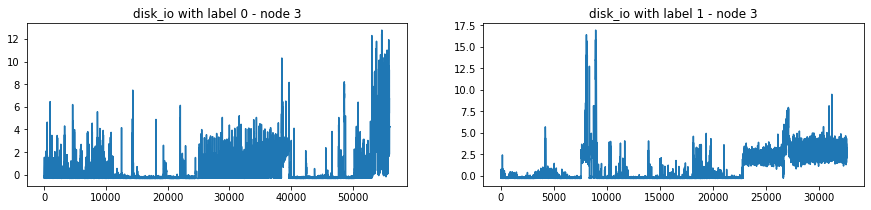

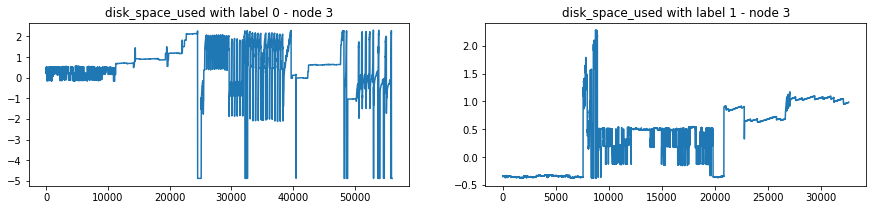

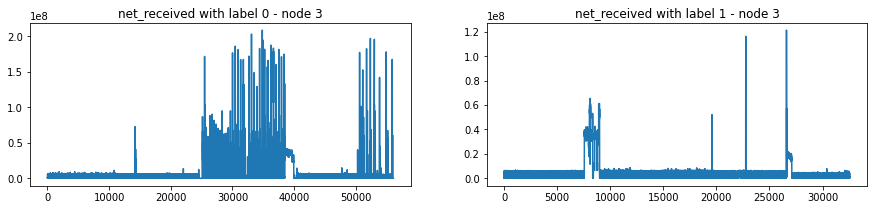

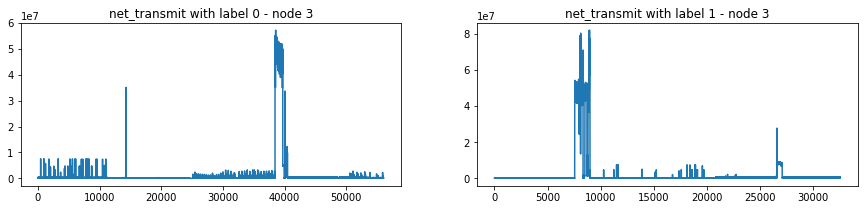

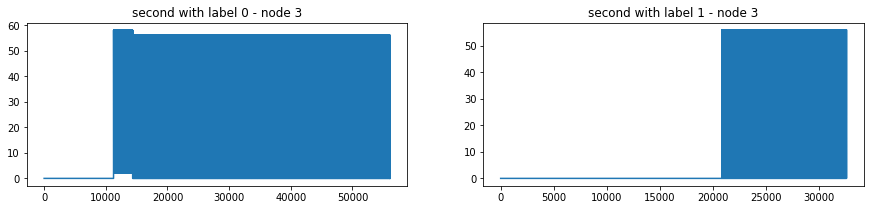

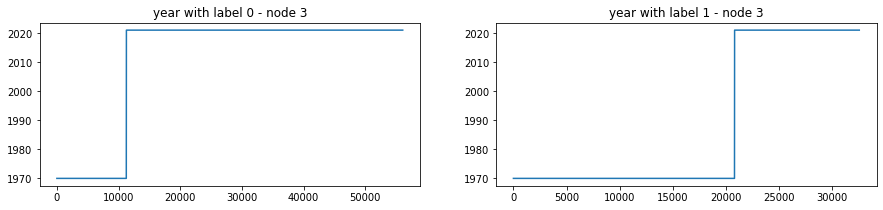

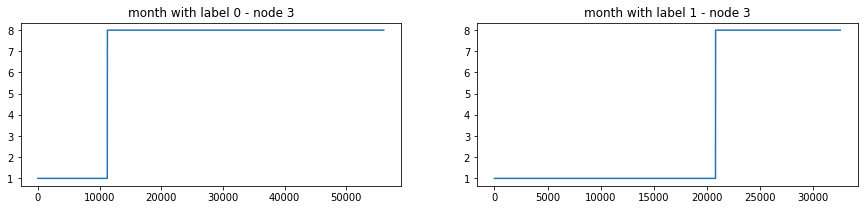

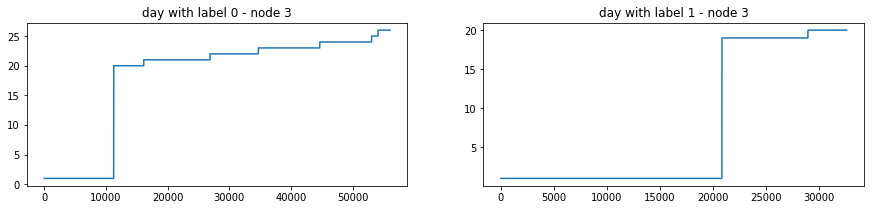

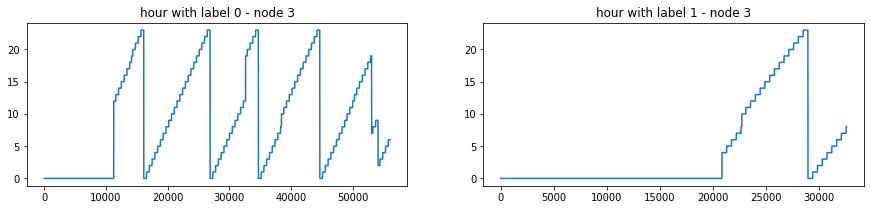

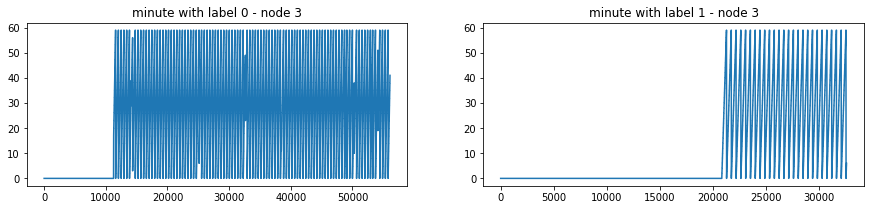

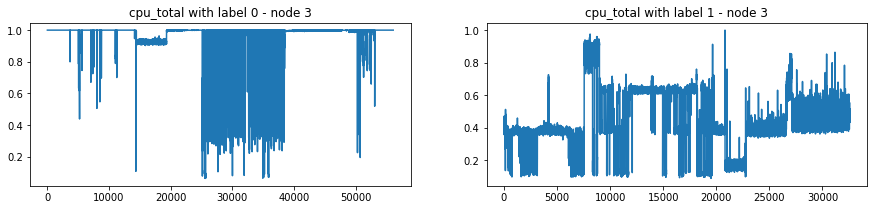

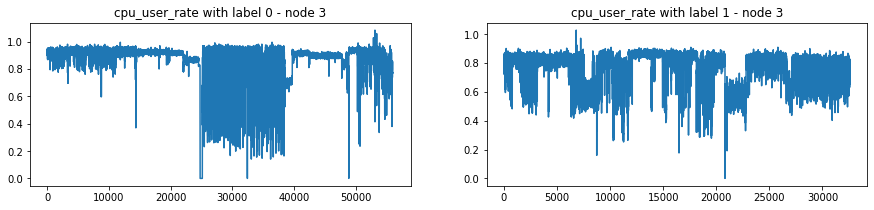

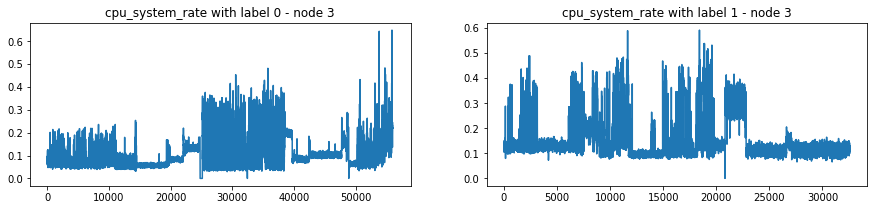

In [18]:
viewAllMetricsByNode(datasetnorm,3)

In [252]:
datasetnorm.groupby('label').mean()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                    
0     -0.342634   0.342743    0.402938 -1.486358  1.527527   -0.023389   
1      0.092831  -0.092861   -0.109170  0.402707 -0.413861    0.006337   

       pod_count  system_load  mem_total  mem_avail  ...      node     second  \
label                                                ...                        
0      -1.110492     1.176268  -0.196141  -0.002018  ...  3.000000  22.487867   
1       0.300871    -0.318692   0.053141   0.000547  ...  1.742991  16.536141   

              year     month        day      hour     minute  cpu_total  \
label                                                                     
0      2010.762538  6.594858  18.092425  8.849846  23.637041   0.963546   
1      2000.063936  5.126423  13.115916  6.423679  17.398652   0.306929   

       cpu_user_rate  cpu_system_rate  
label                                  
0           0.873044         0.101297  
1           0.678997         0.303719  

[2 rows x 24 columns]

In [253]:
datasetnorm.groupby('label').max()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                    
0      1.316907   0.759894   12.163066  1.105443  2.259066   14.495308   
1      1.316907   0.759894    7.121009  2.161289  1.451594   21.471875   

       pod_count  system_load  mem_total  mem_avail  ...  node  second  year  \
label                                                ...                       
0       0.075517     5.104001   3.831745   2.416840  ...     3      58  2021   
1       2.562730     0.797955   2.513972   2.053163  ...     3      58  2021   

       month  day  hour  minute  cpu_total  cpu_user_rate  cpu_system_rate  
label                                                                       
0          8   26    23      59        1.0          1.084         0.647778  
1          8   26    23      59        1.0          8.000         6.958333  

[2 rows x 24 columns]

In [254]:
datasetnorm.groupby('label').min()

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
label                                                                    
0     -0.759553  -1.316735   -1.611627 -1.591235 -1.110367   -0.259443   
1     -0.759559  -1.316735   -1.611627 -1.591235 -1.110367   -0.259443   

       pod_count  system_load  mem_total  mem_avail  ...  node  second  year  \
label                                                ...                       
0      -1.959475    -0.407376  -5.110006  -3.984753  ...     3       0  1970   
1      -1.959475    -0.407376  -5.110006  -3.984753  ...     1       0  1970   

       month  day  hour  minute  cpu_total  cpu_user_rate  cpu_system_rate  
label                                                                       
0          1    1     0       0   0.062667       0.000000         0.000000  
1          1    1     0       0  -0.304333      -1.977528        -1.573034  

[2 rows x 24 columns]

In [255]:
datasetnorm

index  timestamp  cpu_system  cpu_idle  cpu_user  cpu_iowait  \
0      -0.759559   0.759405   -1.101278  1.015298 -0.946661   -0.246918   
1      -0.759559   0.759405   -1.101278  1.015298 -0.946661   -0.246918   
2      -0.759559   0.759405   -0.881544  0.985569 -0.968420   -0.146716   
3      -0.759559   0.759405   -0.881544  0.985569 -0.968420   -0.146716   
4      -0.759559   0.759405   -1.080013  1.021051 -0.970492   -0.259443   
...          ...        ...         ...       ...       ...         ...   
263104 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263105 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263106 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263107 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   
263108 -0.759343   0.759405   -1.611627 -1.591235 -1.110367   -0.259443   

        pod_count  system_load  mem_total  mem_avail  ...  label  second  \
0       -0.602814    -0.405678  -0.896268   0.987362  ...      1       0   
1       -0.602814    -0.405678  -0.896268   0.987362  ...      1       8   
2       -0.602814    -0.405961  -0.895753   0.986829  ...      1      16   
3       -0.602814    -0.405961  -0.895753   0.986829  ...      1      24   
4       -0.602814    -0.406385  -0.896954   0.988074  ...      1      32   
...           ...          ...        ...        ...  ...    ...     ...   
263104  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      24   
263105  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      32   
263106  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      40   
263107  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      48   
263108  -1.507255    -0.407376  -5.110006  -3.984753  ...      0      56   

        year  month  day  hour  minute  cpu_total  cpu_user_rate  \
0       2021      8   21    20       6   0.094000       0.560284   
1       2021      8   21    20       6   0.094000       0.560284   
2       2021      8   21    20       6   0.104333       0.437700   
3       2021      8   21    20       6   0.104333       0.437700   
4       2021      8   21    20       6   0.092000       0.489130   
...      ...    ...  ...   ...     ...        ...            ...   
263104  2021      8   21    19      59   1.000000       0.000000   
263105  2021      8   21    19      59   1.000000       0.000000   
263106  2021      8   21    19      59   1.000000       0.000000   
263107  2021      8   21    19      59   1.000000       0.000000   
263108  2021      8   21    19      59   1.000000       0.000000   

        cpu_system_rate  
0              0.255319  
1              0.255319  
2              0.329073  
3              0.329073  
4              0.271739  
...                 ...  
263104         0.000000  
263105         0.000000  
263106         0.000000  
263107         0.000000  
263108         0.000000  

[263109 rows x 25 columns]

In [19]:
correlation_matrix = datasetnorm.corr()
correlation_matrix["label"]

index              0.178346
timestamp         -0.178403
cpu_system        -0.209736
cpu_idle           0.773672
cpu_user          -0.795101
cpu_iowait         0.012174
pod_count          0.578028
system_load       -0.612265
mem_total          0.102094
mem_avail          0.001050
disk_io           -0.107846
disk_space_used   -0.271426
net_received      -0.033276
net_transmit       0.116286
node              -0.632304
label              1.000000
second            -0.126310
year              -0.178375
month             -0.178375
day               -0.201438
hour              -0.129721
minute            -0.129264
cpu_total         -0.773672
cpu_user_rate     -0.505424
cpu_system_rate    0.515017
Name: label, dtype: float64

<AxesSubplot:>

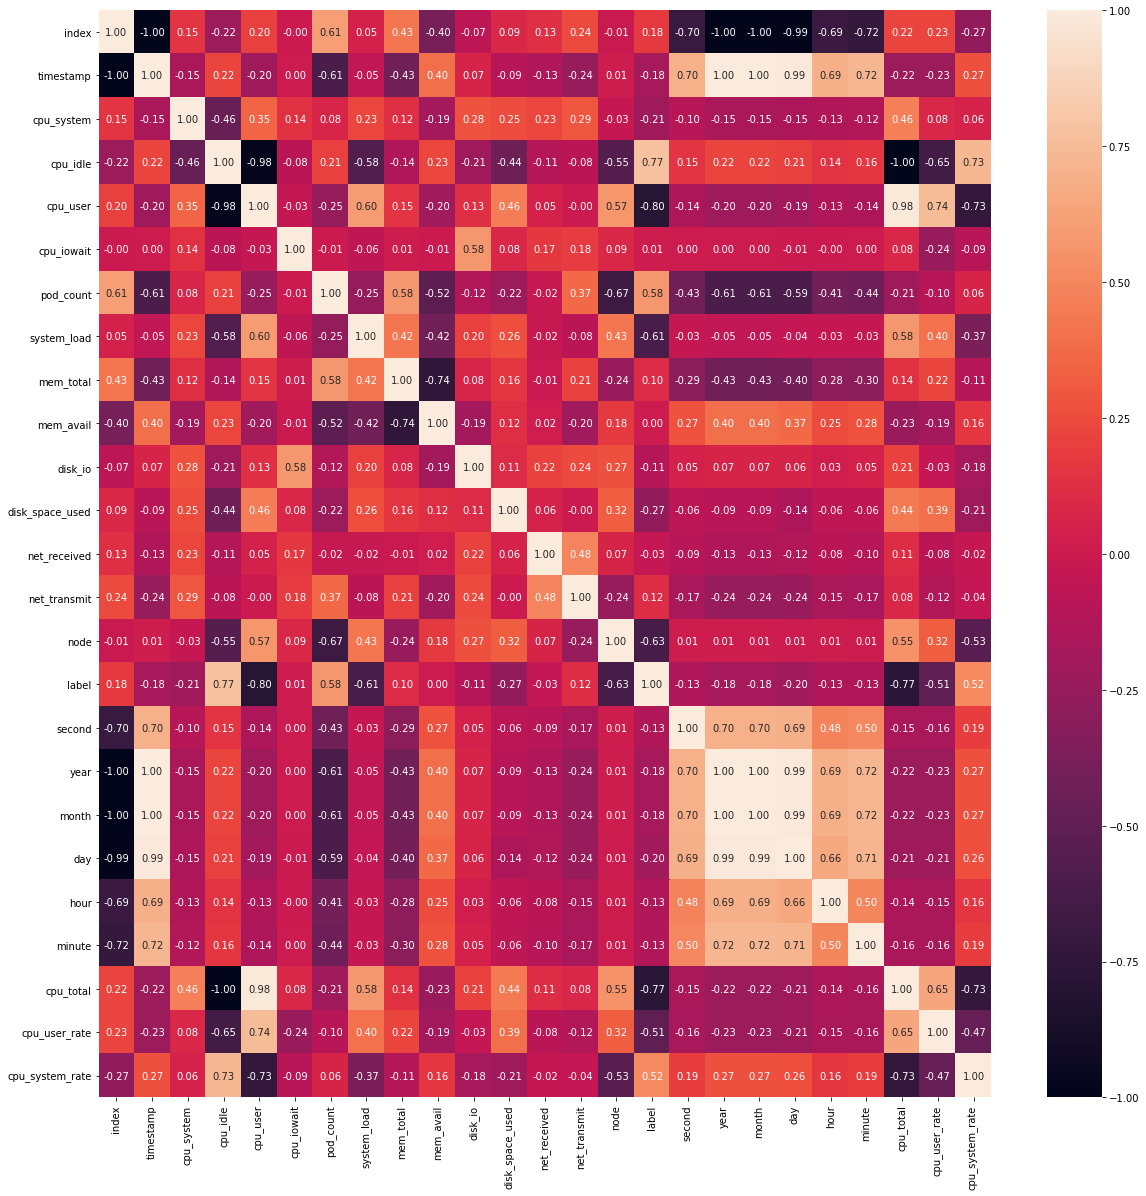

In [20]:
plt.figure(figsize=(20,20))
sn.heatmap(datasetnorm.corr(), annot=True, fmt='.2f')

correlation matrix interpretation:
- CPU Idle (cpu free) increase, label increase and vice versa
- CPU user / CPU total increase, label decrease => If we still have more CPU, label is 1, if users are using more CPU, label is 0
- Pod count increases, label increases
- System load increases, label decrease => System gets more stress => label is 0
- disk space used increase, label decrease => We have less free disk => label is 0

# Rebalance data

In [21]:
def resampleData(dataset,label):
    dataX = dataset.drop(label, axis=1)
    dataY = dataset[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(dataX, dataY)
    result = pd.concat([X_res, y_res], axis=1)
    return result

In [22]:
rsDataset = resampleData(datasetnorm, "label")

In [23]:
print(rsDataset["label"].value_counts())

1    207020
0    207020
Name: label, dtype: int64


--- index
-------Label=0:max 1.3169068780240916  min: -0.7595534423969634
-------Label=1:max 1.3167903391206008  min: -0.7594464711464017
--- timestamp
-------Label=0:max 0.7598941490129197  min: -1.3167354280531822
-------Label=1:max 0.7592402571189971  min: -1.3167354280531822
--- cpu_system
-------Label=0:max 12.163066314874605  min: -1.6116267233948172
-------Label=1:max 3.6832424187604227  min: -1.6116267233948172
--- cpu_idle
-------Label=0:max 1.1054425306833038  min: -1.5912345557969536
-------Label=1:max 1.0306413881703476  min: -1.5912345557969536
--- cpu_user
-------Label=0:max 2.259065965696496  min: -1.110366994892706
-------Label=1:max 0.8924355613227716  min: -1.110366994892706
--- cpu_iowait
-------Label=0:max 14.49530804811659  min: -0.2594431650962717
-------Label=1:max 17.952278620990533  min: -0.2594431650962717
--- pod_count
-------Label=0:max 0.07551703794854892  min: -1.959475235516217
-------Label=1:max 0.07551703794854892  min: -0.828923972480236
--- system_loa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


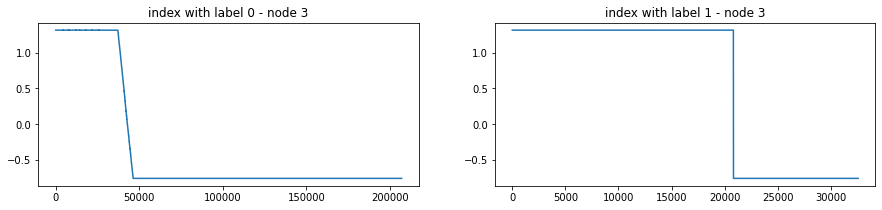

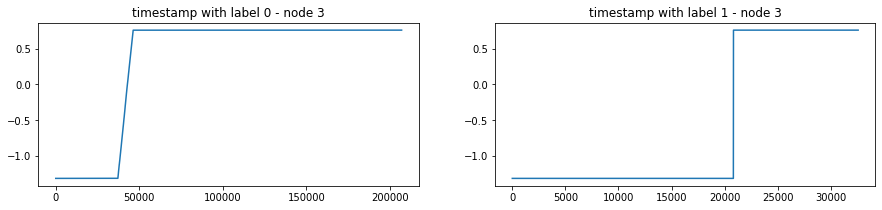

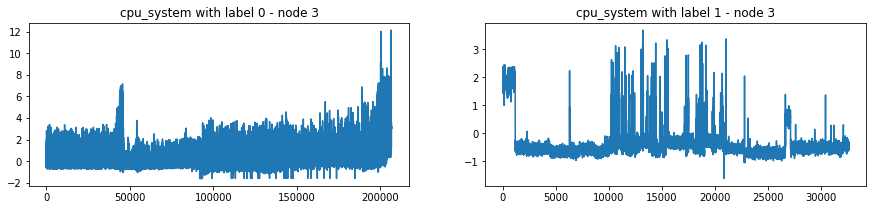

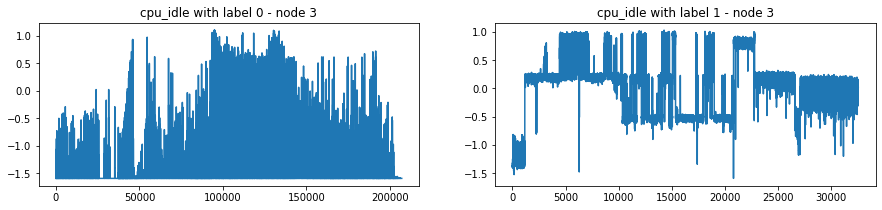

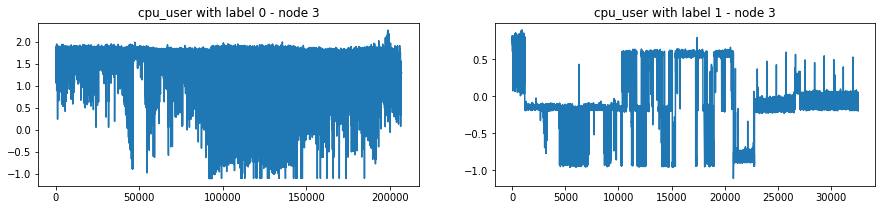

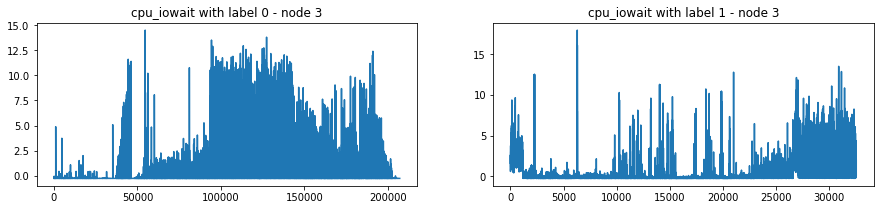

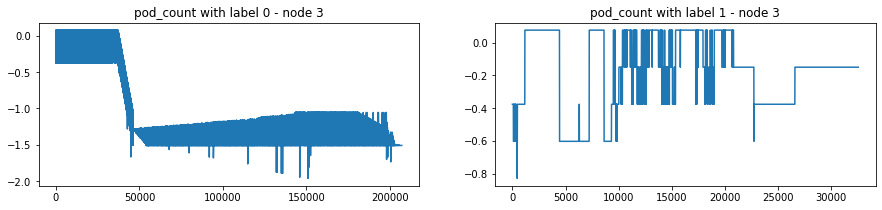

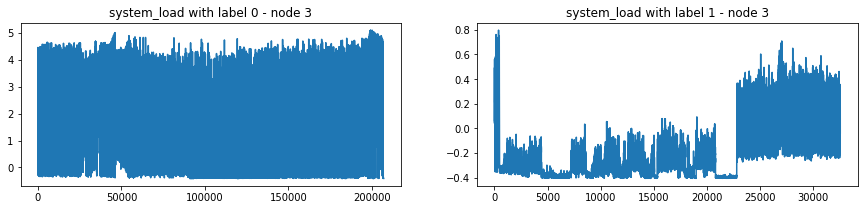

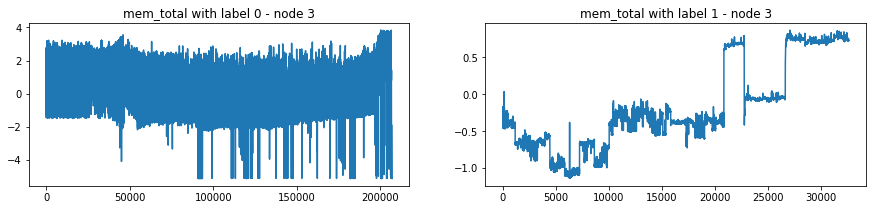

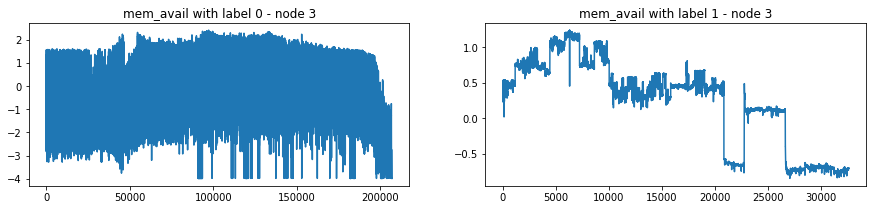

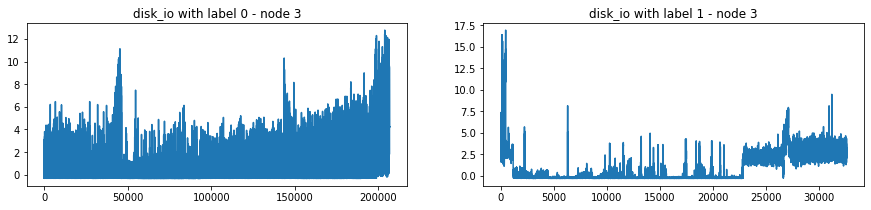

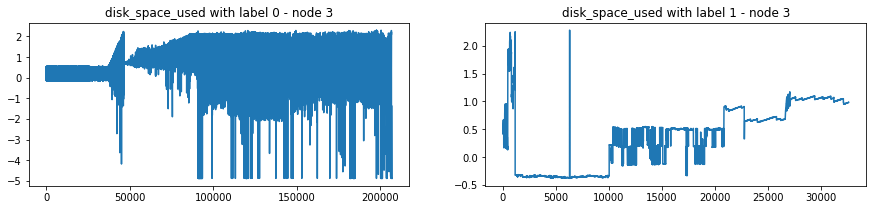

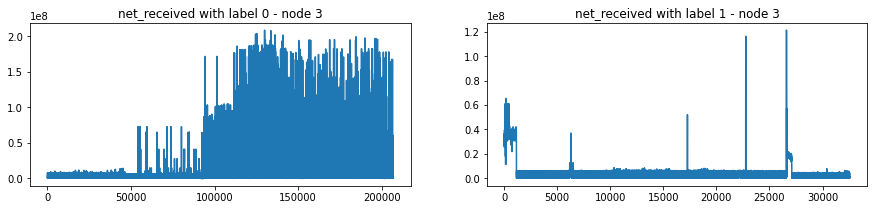

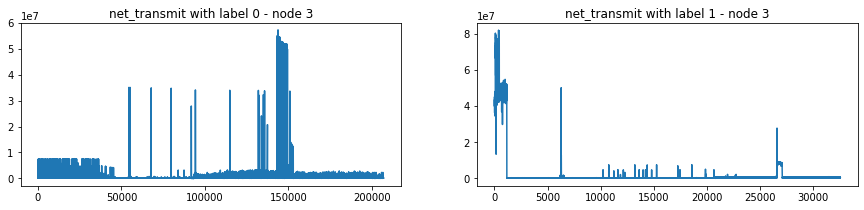

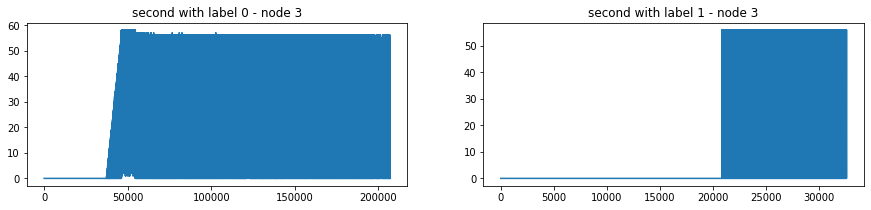

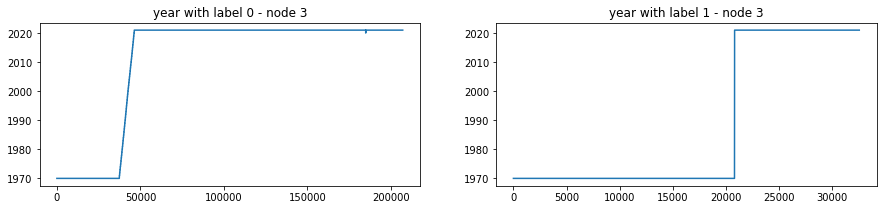

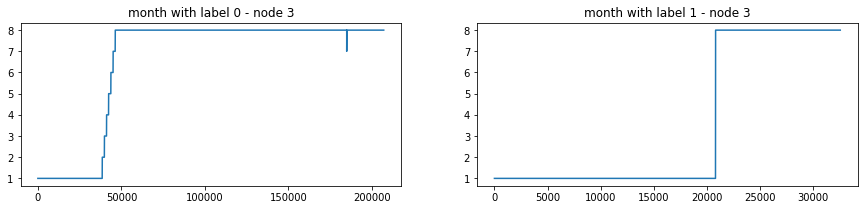

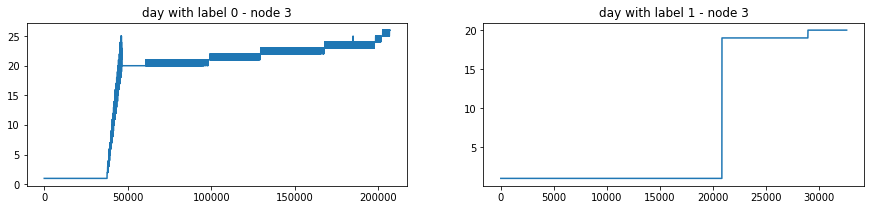

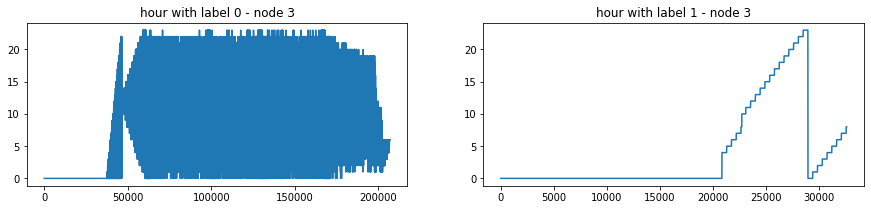

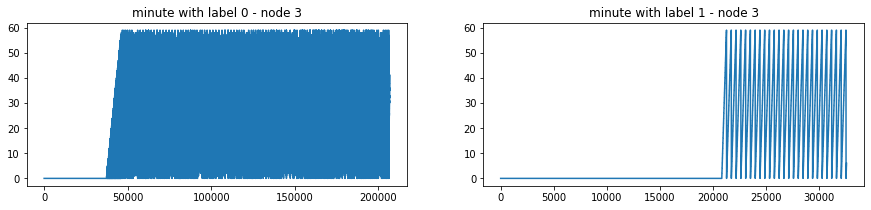

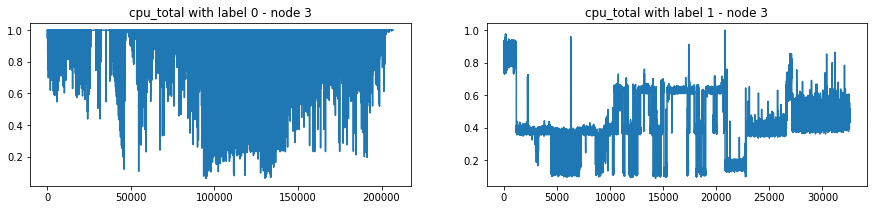

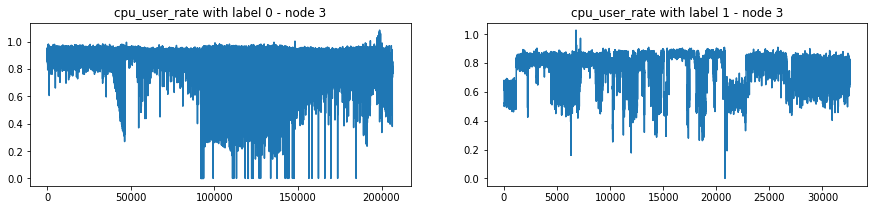

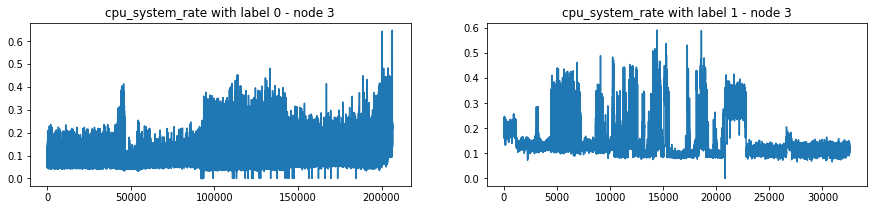

In [24]:
viewAllMetricsByNode(rsDataset,3)

<AxesSubplot:>

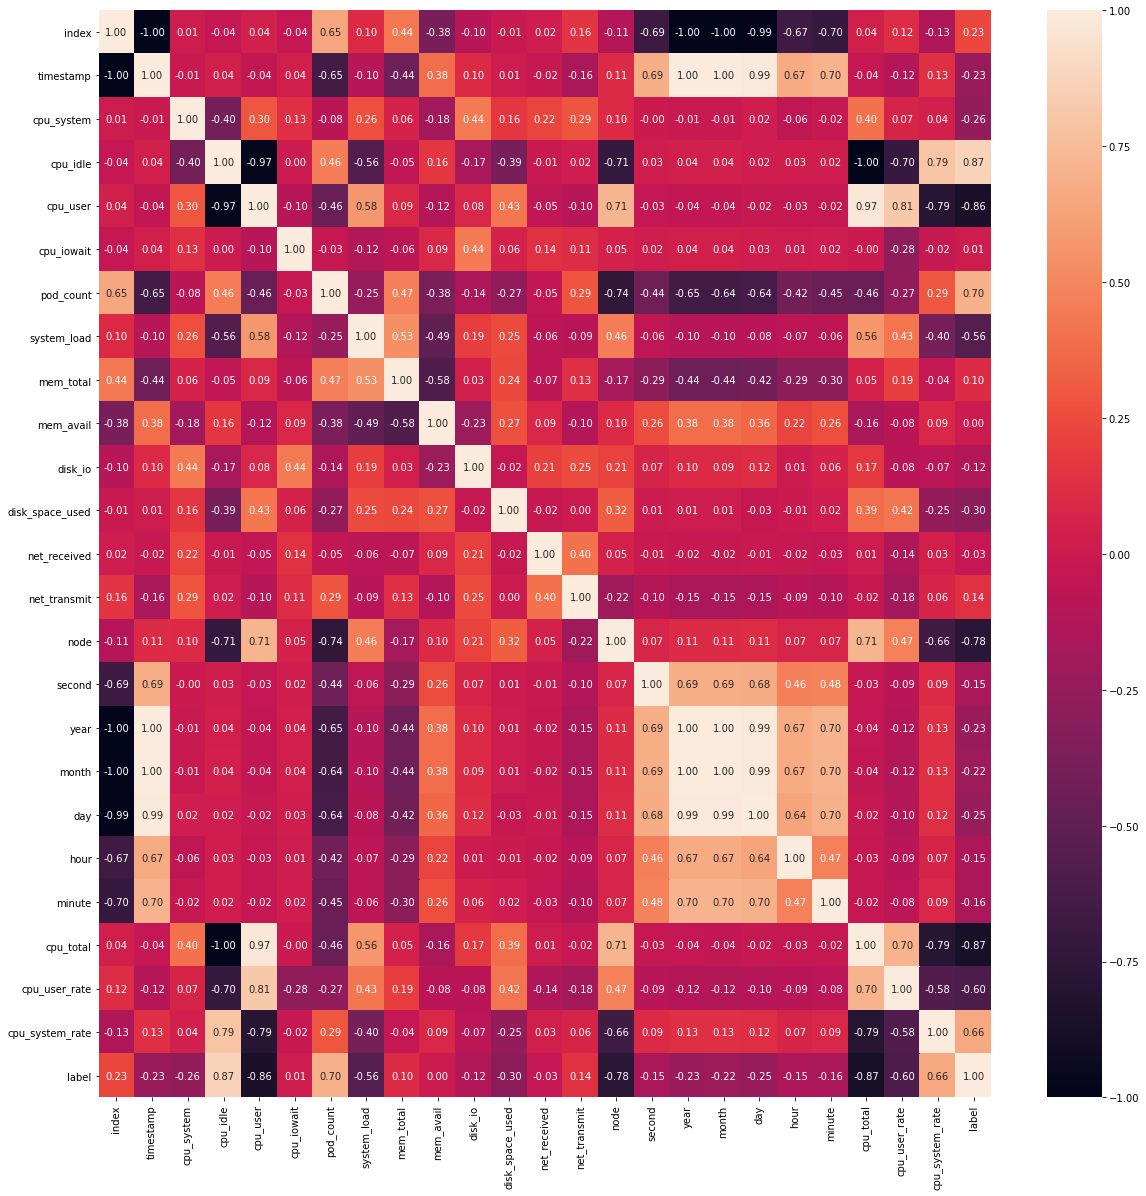

In [25]:
plt.figure(figsize=(20,20))
sn.heatmap(rsDataset.corr(), annot=True, fmt='.2f')

# Split dataset

In [26]:
def splitDataSet(datasetnorms, testSplitPercent):
    #testSplitPercent = 10
    data0 = datasetnorms[datasetnorms["label"]==0]
    data1 = datasetnorms[datasetnorms["label"]==1]
    countAll = datasetnorms["label"].value_counts()
    countAll0 = countAll[0]
    countAll1 = countAll[1]
    countTest0 = int(countAll0 * testSplitPercent / 100 )
    countTest1 = int(countAll1 * testSplitPercent / 100 )
    print("test-0:",countTest0," test-1",countTest1)

    dataTest0 = data0.tail(countTest0)
    dataTest1 = data1.tail(countTest1)

    dataTrain0 = data0.head(-countTest0)
    dataTrain1 = data1.head(-countTest1)
    print("All-0",countAll0," All-1",countAll1)
    print("test-0:",dataTest0["label"].value_counts()[0]," test-1",dataTest1["label"].value_counts()[1])
    print("train-0:",dataTrain0["label"].value_counts()[0]," train-1",dataTrain1["label"].value_counts()[1])

    dataTrainM = pd.concat([dataTrain0, dataTrain1])
    dataTestM = pd.concat([dataTest0, dataTest1])
    print("MergeTrain:")
    print(dataTrainM["label"].value_counts())

    print("MergeTest:")
    print(dataTestM["label"].value_counts())
    
    dataTrainMX = dataTrainM.drop("label", axis=1)
#     dataTrainMX = dataTrainMX.values
    dataTrainMY = dataTrainM["label"]
#     dataTrainMY = dataTrainMY.values

    dataTestMX = dataTestM.drop("label", axis=1)
#     dataTestMX = dataTestMX.values
    dataTestMY = dataTestM["label"]
#     dataTestMY = dataTestMY.values

    return (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY)

In [27]:
datasetnorm = rsDataset

# KNN Simple

In [265]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)


In [266]:
nDatasetNormKnn.head()

cpu_system  cpu_idle  cpu_user  cpu_iowait  pod_count  system_load  \
0   -1.101278  1.015298 -0.946661   -0.246918  -0.602814    -0.405678   
1   -1.101278  1.015298 -0.946661   -0.246918  -0.602814    -0.405678   
2   -0.881544  0.985569 -0.968420   -0.146716  -0.602814    -0.405961   
3   -0.881544  0.985569 -0.968420   -0.146716  -0.602814    -0.405961   
4   -1.080013  1.021051 -0.970492   -0.259443  -0.602814    -0.406385   

   mem_total  mem_avail   disk_io  disk_space_used   net_received  \
0  -0.896268   0.987362 -0.310362        -0.704699  951905.066667   
1  -0.896268   0.987362 -0.310362        -0.704699  951905.066667   
2  -0.895753   0.986829 -0.290475        -0.702686  771843.200000   
3  -0.895753   0.986829 -0.290475        -0.702686  771843.200000   
4  -0.896954   0.988074 -0.326271        -0.702682  849244.266667   

    net_transmit  cpu_total  cpu_user_rate  cpu_system_rate  label  
0  899240.000000   0.094000       0.560284         0.255319      1  
1  899240.000000   0.094000       0.560284         0.255319      1  
2  541984.000000   0.104333       0.437700         0.329073      1  
3  541984.000000   0.104333       0.437700         0.329073      1  
4  771101.333333   0.092000       0.489130         0.271739      1

In [310]:
nDatasetNormKnn.shape

(414040, 16)

In [311]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 30)

test-0: 20702  test-1 20702
All-0 207020  All-1 207020
test-0: 20702  test-1 20702
train-0: 186318  train-1 186318
MergeTrain:
1    186318
0    186318
Name: label, dtype: int64
MergeTest:
1    20702
0    20702
Name: label, dtype: int64


In [268]:
def KnnCalculate(trainX,trainY,testSingleX):
    distances = np.linalg.norm(trainX - testSingleX, axis=1)
    k = 1
    nearest_neighbor_ids = distances.argsort()[:k]
    nearest_label = trainY[nearest_neighbor_ids]
    return nearest_label[0]
    
def KnnPredict(trainX,trainY,testX,testY):
    yLs = []
    acs = 0
    acc = 0
    for xi in range(0,len(testX)):
        yn = KnnCalculate(trainX,trainY,testX[xi])
        if yn == testY[xi]:
            acc = acc + 1
        acs = acs + 1 
        yLs.append(yn)
#     print(yLs)
#     print(testY)
    accuracy = acc / acs
    return (accuracy)
# new_data_point = np.array([[0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208],[0.569552,0.446407,0.154437,1.016849,0.439051,0.222526,0.291208]])    
# KnnPredict(X,y,new_data_point,[9,10])

In [269]:
print("KNN Accuracy")
KnnPredict(dataTrainMX.values, dataTrainMY.values, dataTestMX.values, dataTestMY.values)

KNN Accuracy


0.9877065017872669

# Regression Logic

In [270]:
!pip3 install statsmodels

we should remove all attribute having pvalue < 0.05

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.


Ref: 
https://blog.minitab.com/en/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients
https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

In [279]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
# nDatasetNormKnn = nDatasetNormKnn.drop("cpu_system", axis=1).drop("mem_avail", axis=1)
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 10)
dataTrainMX = nDatasetNormKnn.drop("label", axis=1)
#Drop because p-value > 0.05
dataTrainMX = dataTrainMX.drop("system_load", axis=1).drop("mem_avail", axis=1).drop("mem_total", axis=1).drop("disk_io", axis=1).drop("cpu_iowait", axis=1)
#Drop because coef ~ 0
# dataTrainMX = dataTrainMX.drop("net_transmit", axis=1)
dataTrainMY = nDatasetNormKnn["label"]
    

In [280]:
import statsmodels.api as sm
logit_model=sm.Logit(dataTrainMY,dataTrainMX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.001163
         Iterations 17
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.998      
Dependent Variable:  label            AIC:              983.0485   
Date:                2021-08-30 13:52 BIC:              1092.3857  
No. Observations:    414040           Log-Likelihood:   -481.52    
Df Model:            9                LL-Null:          -2.8699e+05
Df Residuals:        414030           LLR p-value:      0.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      17.0000                                       
-------------------------------------------------------------------
                 Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------
cpu_system        1.6279   0.2234   7.2865 0.0000   1.1900   2.0658
cpu_idle          5.5068   1.8759   2.93

In [273]:
# !pip3 install scikit-learn

In [32]:
X_train, X_test, y_train, y_test = train_test_split(dataTrainMX,dataTrainMY, test_size=0.1, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

NameError: name 'dataTrainMX' is not defined

In [284]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78118


In [285]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18573
           1       0.83      0.70      0.76     18691

    accuracy                           0.78     37264
   macro avg       0.79      0.78      0.78     37264
weighted avg       0.79      0.78      0.78     37264



# Random Forest Classifier

In [335]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 10)


In [287]:
modelForestClassifier = RandomForestClassifier(n_estimators=1000)
modelForestClassifier.fit(dataTrainMX, dataTrainMY)

RandomForestClassifier(n_estimators=1000)

In [288]:
y_pred_test = modelForestClassifier.predict(dataTestMX)
print("Accuracy score:",accuracy_score(dataTestMY, y_pred_test))

Accuracy score: 1.0


In [289]:
confusion_matrix(dataTestMY, y_pred_test)

array([[20702,     0],
       [    0, 20702]])

In [290]:
print(classification_report(dataTestMY, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20702
           1       1.00      1.00      1.00     20702

    accuracy                           1.00     41404
   macro avg       1.00      1.00      1.00     41404
weighted avg       1.00      1.00      1.00     41404



In [294]:
from sklearn.tree import export_graphviz
from IPython.display import Image

def drawForestTree(estimator,feature_names,class_names, treeName):
#     fig = plt.figure(figsize=(15, 10))
#     plot_tree(estimator, 
#               feature_names=feature_names,
#               class_names=class_names, 
#               filled=True, impurity=True, 
#               rounded=True)

    
    export_graphviz(estimator, out_file='tree_limited.dot', feature_names = feature_names,
                    class_names = class_names,
                    rounded = True, proportion = False, precision = 2, filled = True)
    !dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=300

In [295]:
drawForestTree(modelForestClassifier.estimators_[2],list(dataTrainMX.columns.values),["Bad","Good"],"Model Forest Classifier")
Image(filename = 'tree_limited.png')


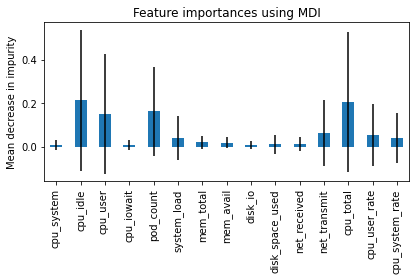

In [296]:
importances = modelForestClassifier.feature_importances_

forest_importances = pd.Series(importances, index=list(dataTrainMX.columns.values))
std = np.std([
    tree.feature_importances_ for tree in modelForestClassifier.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

=> I dont understand why the std of some features are too high

# XGBoost

In [297]:
# !apt-get update -y
# !apt-get install build-essential -y
# !pip3 install cmake --upgrade

In [298]:
# !pip3 install xgboost --upgrade

In [299]:
#In case it does not work
# !rm -rf /root/.local/lib/python3.6/site-packages/xgboost
# !rm -rf xgboost
# !git clone --recursive https://github.com/dmlc/xgboost.git
# !cd xgboost && make
# !cd xgboost/python-package && python3 setup.py install --user

In [40]:
import xgboost

In [34]:
nDatasetNormKnn = datasetnorm.drop("year", axis=1).drop("month", axis=1).drop("day", axis=1).drop("hour", axis=1).drop("minute", axis=1).drop("second", axis=1).drop("timestamp", axis=1).drop("node", axis=1).drop("index", axis=1)
# (dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSet(nDatasetNormKnn, 99)


In [35]:
def splitDataSetSKLearn(datasetnorms, testSplitPercent):
    dataAllX = datasetnorms.drop("label", axis=1)
    dataAllY = datasetnorms["label"]
    X_train, X_test, y_train, y_test = train_test_split(dataAllX, dataAllY, test_size=testSplitPercent)
    print("splitDataSet with sklearn")
    print("Train")
    print(X_train.shape)
    print("Test")
    print(X_test.shape)
    return (dataAllX,dataAllY,X_train,y_train,X_test,y_test)
# splitDataSetSKLearn(nDatasetNormKnn,70)

In [36]:
(dataTrainM, dataTestM, dataTrainMX, dataTrainMY, dataTestMX, dataTestMY) = splitDataSetSKLearn(nDatasetNormKnn, 0.999)


splitDataSet with sklearn
Train
(414, 15)
Test
(413626, 15)


In [38]:
print(dataTrainMX.shape)
print()

(414, 15)



In [41]:
modelXGboost = xgboost.XGBRFClassifier(n_estimators=100,objective='binary:logistic')
modelXGboost.fit(dataTrainMX.to_numpy(), dataTrainMY.to_numpy())

[12:33:14] WARNING: /tmp/pip-build-5iihhz2k/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=6, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [48]:
featureList = list(dataTrainMX.columns.values)

In [46]:
y_pred = modelXGboost.predict(dataTestMX.to_numpy())
print("Accuracy score:",accuracy_score(dataTestMY, y_pred))

Accuracy score: 0.997224545845764


In [306]:
#!apt-get install graphviz -y
# from xgboost import plot_tree

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

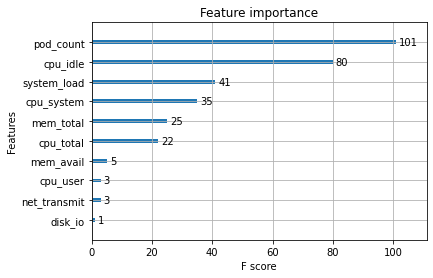

In [49]:
modelXGboost.get_booster().feature_names = featureList
xgboost.plot_importance(modelXGboost.get_booster())

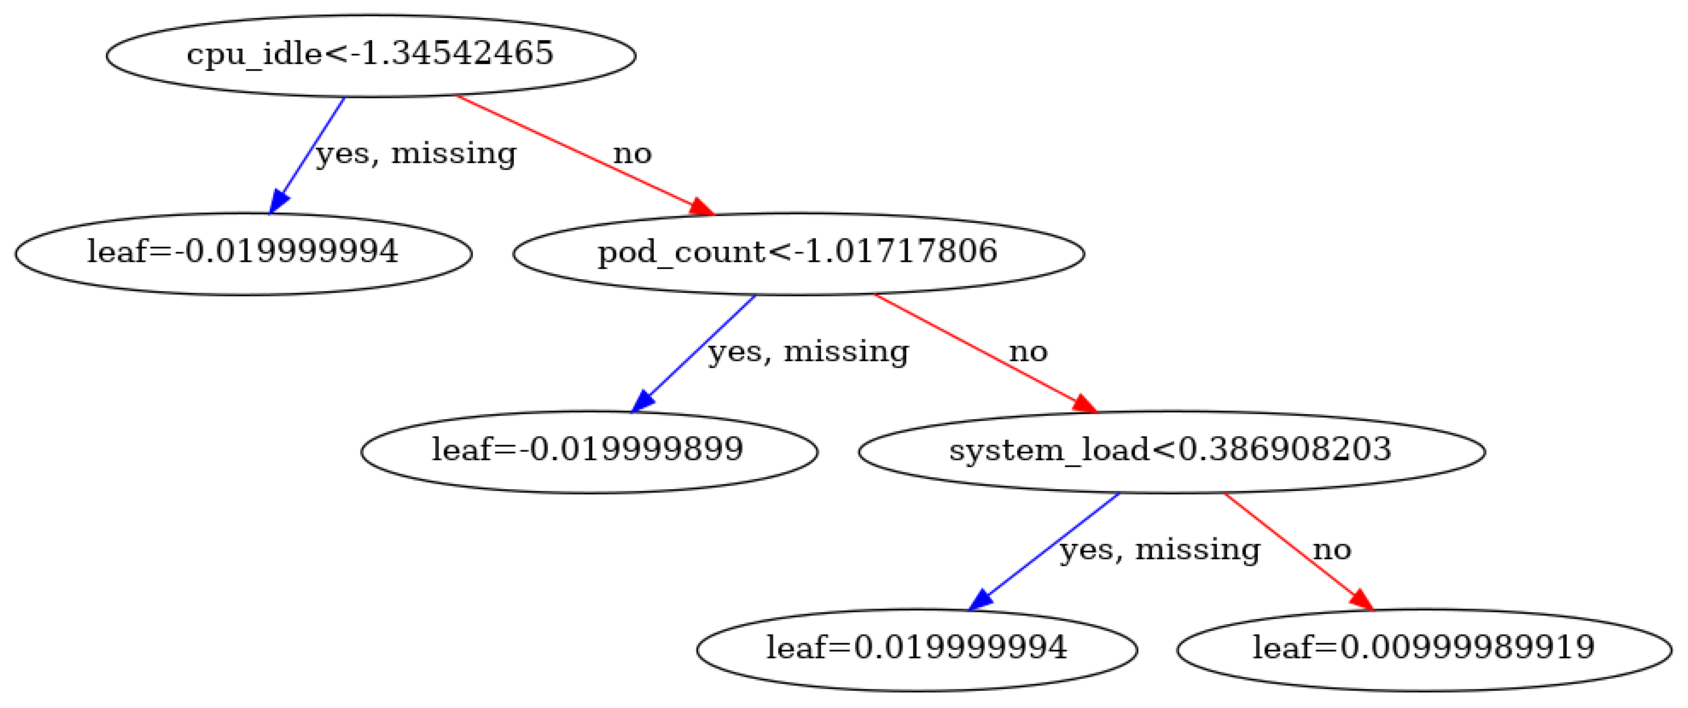

In [50]:
# plot_tree(modelXGboost)
# plt.figure(figsize=(200,200))  # set plot size (denoted in inches)
# plt.show()

fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(modelXGboost, num_trees=10, ax=ax)
plt.show()

Attribute leaf is the predicted value. In other words, if the evaluation of a tree model ends at that terminal node (aka leaf node), then this is the value that is returned.

For class 1 probability 1/(1+np.exp(-1* leaf_value))

leaf_value < 0 => Class 0

leaf_value > 0 => Class 1


# Result discussion

Simple KNN: 98% => Its super slow in both training and prediction

Regression Logic: 75% => Training fast

Random Forest Classifier: 100% => Training slow

XGBoost: 99% => Training fast

=> Problem of overfitting ?

In [51]:
adriana.motter@comune.trento.it

cross validation => k fold : 20% test and 80% train
=> 5 fold 

SyntaxError: invalid syntax (<ipython-input-51-c87f40fd3b2a>, line 3)